In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["SMITHERY_API_KEY"] = os.getenv("SMITHERY_API_KEY")

In [3]:
llm = ChatGroq(
    model= "llama-3.3-70b-versatile"
)

agent_llm = ChatGroq(
    model="openai/gpt-oss-20b"
)

In [4]:
llm.invoke("hi")

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.035100865, 'prompt_time': 0.010927027, 'queue_time': 0.04890953, 'total_time': 0.046027892}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--15870ec3-dfbf-4016-8ee0-c370f85dc9d2-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [5]:
# text to image https://pollinations.ai/
from urllib.parse import quote

def image_generation(prompt : str):
    encoded_prompt = quote(prompt)
    image_url = f"https://image.pollinations.ai/prompt/{encoded_prompt}"
    
    return image_url

In [6]:
from langchain_mcp_adapters.client import MultiServerMCPClient

In [7]:
url1 = "https://server.smithery.ai/exa/mcp?api_key=6b22a5b2-d640-40fe-b823-f62c5a83063b&profile=sacred-guanaco-pEmpOL"

async def tool_1():
    # Create an MCP client with HTTP transport
    client = MultiServerMCPClient({
        "server1": {
            "url": url1,
            "transport": "streamable_http",
        }
    })
    
    # Get tools from all servers
    tools = await client.get_tools()
    return tools

In [8]:
mcp_tools = await tool_1()

In [9]:
mcp_tools

[StructuredTool(name='web_search_exa', description='Search the web using Exa AI - performs real-time web searches and can scrape content from specific URLs. Supports configurable result counts and returns the content from the most relevant websites.', args_schema={'type': 'object', 'properties': {'query': {'type': 'string', 'description': 'Search query'}, 'numResults': {'type': 'number', 'description': 'Number of search results to return (default: 5)'}}, 'required': ['query'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000029B4EC405E0>),
 StructuredTool(name='company_research_exa', description='Research companies using Exa AI - finds comprehensive information about businesses, organizations, and corporations. Provides insights into company operations, news, financial information, and industry analysis.', args_schema={'type': 

In [10]:
mcp_tools = mcp_tools

In [11]:
mcp_tools

[StructuredTool(name='web_search_exa', description='Search the web using Exa AI - performs real-time web searches and can scrape content from specific URLs. Supports configurable result counts and returns the content from the most relevant websites.', args_schema={'type': 'object', 'properties': {'query': {'type': 'string', 'description': 'Search query'}, 'numResults': {'type': 'number', 'description': 'Number of search results to return (default: 5)'}}, 'required': ['query'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000029B4EC405E0>),
 StructuredTool(name='company_research_exa', description='Research companies using Exa AI - finds comprehensive information about businesses, organizations, and corporations. Provides insights into company operations, news, financial information, and industry analysis.', args_schema={'type': 

### Agent

In [95]:
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Annotated
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.prebuilt import create_react_agent


In [96]:
decision_system_prompt = """
    You are an assistant that determines the user's intent from a prompt. 
    Return only ONE of these keywords exactly: Q&A, LatestInfo, Image, PlatformContent, Unknown.

    Here is what each option means:
    - Q&A: The user wants an answer to a factual or general knowledge question.
    - LatestInfo: The user wants real-time or recent information from the internet (e.g., weather, news).
    - Image: The user wants to generate an image based on a description.
    - PlatformContent: The user wants content tailored for a specific platform (e.g., Facebook, LinkedIn, Twitter).

    Do NOT include any explanations, punctuation, or extra text. Return ONLY the keyword exactly as listed above.
"""

In [97]:
tailor_system_prompt = """
You are a Social Media Content Tailoring Assistant.
Your task is to take a single base message and rewrite it so it is optimized for specific platforms such as Facebook, LinkedIn, and Twitter/X.

Rules:
1. Keep the core meaning of the message intact.
2. Adjust tone, length, and style to match the platform’s audience and norms.
3. Facebook: friendly, conversational, slightly longer, encourage sharing, can use emojis.
4. LinkedIn: professional, benefit-oriented, concise but informative, avoid slang, focus on business/research impact.
5. Twitter/X: short, attention-grabbing, hashtags allowed, max 280 characters, punchy tone.
6. Do not fabricate information — only reframe the original message.

Example Output:
{
  "facebook": "🚀 We’ve launched our new AI Image Generator! Type anything you imagine and watch it come to life instantly. Share your creations with friends! 👉 [link]",
  "linkedin": "Excited to launch our AI Image Generator! This tool helps creatives and businesses turn ideas into visuals in seconds, saving time and boosting creativity. Explore: [link]",
  "twitter": "🚀 Just launched: AI Image Generator! Turn words → art in seconds. Try it: [link] #AI #Innovation"
}
"""

In [98]:
# class State(TypedDict):
#     messages : Annotated[list, add_messages]

In [99]:
class RouteDecision(BaseModel):
    step : Literal["Q&A", "LatestInfo", "Image", "PlatformContent"] = Field(description="The next step in the routing process.")
    
llm_with_decision = llm.with_structured_output(RouteDecision)

In [191]:
class State(TypedDict):
    input : str
    decision : str
    output : str

#### Define node

In [192]:
serach_agent = create_react_agent(
    model = agent_llm,
    tools=mcp_tools
)

In [193]:
# Node 1
def q_and_a(state : State): # Done
    """Q&A"""
    result = llm.invoke(state["input"])
    return {"output" : result.content}

# Node 2
async def latest_info(state: State): # Done
    search_response = await serach_agent.ainvoke(
        {"messages" : [{"role" : "user", "content" : state["input"]}]}
    )
    return {"output" : search_response["messages"]}
    

# Node 3
def img_gen(state : State): # Done
    img_url = image_generation(state["input"])
    return {"output" : img_url}

# Node 4
def content_tailor(state : State):
    result = llm.invoke(
        [
            SystemMessage(content=tailor_system_prompt),
            HumanMessage(content=state["input"])
        ]
    )
    return {"output" : result.content}

# Node 5
def call_router(state : State):
    """Route the input to the appropriate node"""
    
    decision = llm_with_decision.invoke(
        [
            SystemMessage(
                content=decision_system_prompt
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision" : decision.step}


In [194]:
# conditional function to route the node
def route_decision(state : State):
    if state["decision"] == "Q&A":
        return "q_and_a"
    elif state["decision"] == "LatestInfo":
        return "latest_info"
    elif state["decision"] == "Image":
        return "img_gen"
    elif state["decision"] == "PlatformContent":
        return "content_tailor"
    else:
        return "q_and_a"

In [198]:
graph_builder = StateGraph(State)

# Add Node
graph_builder.add_node("call_router", call_router)
graph_builder.add_node("q_and_a", q_and_a)
graph_builder.add_node("latest_info", latest_info)
graph_builder.add_node("img_gen", img_gen)
graph_builder.add_node("content_tailor", content_tailor)
# graph_builder.add_node("tools", ToolNode(mcp_tools))

# Add Edge
graph_builder.add_edge(START, "call_router")
graph_builder.add_conditional_edges(
    "call_router",
    route_decision,
    {
        "q_and_a" : "q_and_a",
        "latest_info" : "latest_info",
        "img_gen" : "img_gen",
        "content_tailor" : "content_tailor"
    }
)

graph_builder.add_edge("q_and_a", END)
graph_builder.add_edge("img_gen", END)
graph_builder.add_edge("content_tailor", END)
graph_builder.add_edge("latest_info", END)

# graph_builder.add_conditional_edges(
#     "latest_info",
#     tools_condition
# )


graph = graph_builder.compile()


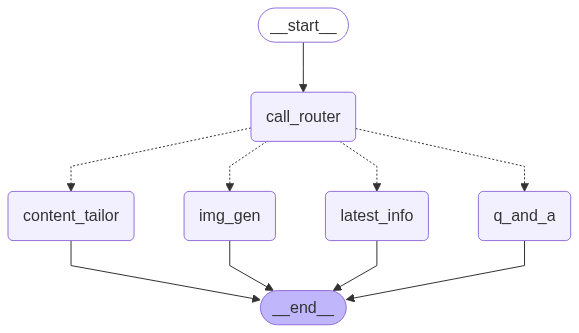

In [199]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [200]:
config = {
    "configurable" : {"thread_id" : '42'}
}

state = await graph.ainvoke(
    {
        "input" : "hi"
    },
    config = config
)
state

{'input': 'hi',
 'decision': 'Q&A',
 'output': "It's nice to meet you. Is there something I can help you with or would you like to chat?"}

### Routing process
